**Import Important Libraries**

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
#import scipy.sparse.linalg
from sklearn.impute import SimpleImputer

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
import xgboost as xgb

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
#Warnings - Ignore All
import warnings
warnings.simplefilter('ignore')

In [11]:
#Ignore All Warnings About Later Execution
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Data Collection**

In [12]:
train_values = pd.read_csv('./data/Training set values.csv')
train_labels = pd.read_csv('./data/Training set labels.csv')
test_values  = pd.read_csv('./data/Test set values.csv')

**Statistical Summary**

In [13]:
#
print('Train examples: ', len(train_values))

print('Test examples: ',  len(test_values))

Train examples:  59400
Test examples:  14850


In [ ]:
# print("Number of rows: "+str(full_data.shape[0]))
# print("Number of columns: "+str(full_data.shape[1]))

In [14]:
#
train_values.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [15]:
#
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

**Data Merge**

In [16]:
train_data_complete = pd.merge(train_values, train_labels, left_on='id', right_on='id', how='left').drop('id', axis=1) 

**Data Cleaning**

In [17]:
#Drop Redundant Columns
features_to_drop = ['date_recorded']

In [18]:
train_data_v1 = train_data_complete.drop(features_to_drop, axis=1)  

***Missing Data Imputation***

In [19]:
#
nullseries = train_data_v1.isnull().sum().sort_values(ascending=False)
nullseries[nullseries > 0]

scheme_name          28166
scheme_management     3877
installer             3655
funder                3635
public_meeting        3334
permit                3056
subvillage             371
dtype: int64

In [20]:
def impute_features(df):
    """
    Impute missing values in continuous and categorical features using SimpleImputer
    
    Args:
    - df: Pandas DataFrame with continuous and categorical features
    - strategy: string, strategy to use for imputation (default: 'median')
    
    Returns:
    - Pandas DataFrame with imputed values
    """
    # identify continuous and categorical columns
    cont_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns
    
    # impute missing values in continuous columns
    cont_imputer = SimpleImputer(strategy='median')
    df[cont_cols] = cont_imputer.fit_transform(df[cont_cols])
    
    # impute missing values in categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    return df


In [21]:
train_data_v2 = impute_features(train_data_v1)

***Feature Scaling***

In [22]:

def scale_continuous_features(df):
    """
    Scales the continuous variables in a dataframe using the scikit-learn StandardScaler.

    Args:
        df (pandas.DataFrame): The dataframe to scale.

    Returns:
        pandas.DataFrame: The scaled dataframe.
    """
    # Extract the continuous features
    continuous_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
    if len(continuous_cols) == 0:
        print("No continuous features found in dataframe.")
        return df

    # Scale the continuous features
    scaler = StandardScaler()
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

    return df


In [23]:
train_data_v3 = scale_continuous_features(train_data_v2)

**Encode Features and Feature Selection and Feature Engineering**

In [23]:
from featurewiz import featurewiz

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [24]:
import featurewiz as FW
train_data_v4, test_data_v4 = FW.featurewiz(dataname=train_data_v3, target='status_group', corr_limit=0.90, verbose=1, sep=',', 
		header=0, test_data=test_values,feature_engg="", category_encoders='TargetEncoder',
		dask_xgboost_flag=False, nrows=None)

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (59400, 39)
#### Single_L

**Distribution of Independent Variables**

*Actual Labels*

In [25]:
y_actual_labels = train_labels['status_group']

In [26]:
y_actual_labels.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

*Modified Labels*

In [27]:
y_modified_labels = train_data_v4['status_group']

In [28]:
y_modified_labels.value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

*Encode Labels*

In [29]:
y = train_labels['status_group']
le = LabelEncoder()

Y  = le.fit_transform(train_labels['status_group'])

In [30]:
len(Y)

59400

**Data Splitting**

In [33]:
X = train_data_v4.drop('status_group', axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=Y, test_size = 0.3, random_state = 42)

**Data Modeling**

In [36]:
from lazypredict.Supervised import LazyClassifier

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

In [51]:
file_name = "models.csv"
models.to_csv(file_name, sep='\t')

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
from sklearn import metrics
# We are going to run it for k = 1 to 15 and will be recording testing accuracy, plotting it, showing confusion matrix and classification report:
range_k = range(1,15)
scores = {}
scores_list = []
for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(X_train, y_train)
   y_pred = classifier.predict(X_test)
   scores[k] = metrics.accuracy_score(y_test,y_pred)
   scores_list.append(metrics.accuracy_score(y_test,y_pred))
result = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[7797  149 1732]
 [ 785  213  297]
 [2917  108 3822]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      9678
           1       0.45      0.16      0.24      1295
           2       0.65      0.56      0.60      6847

    accuracy                           0.66     17820
   macro avg       0.59      0.51      0.53     17820
weighted avg       0.65      0.66      0.65     17820



Text(0, 0.5, 'Accuracy')

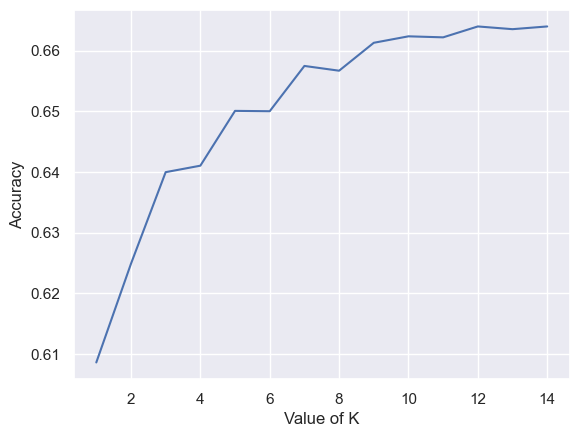

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
k_range = range(1,15)
plt.plot(k_range,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

In [48]:
classifier = KNeighborsClassifier(n_neighbors = 14)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

In [50]:
classifier.predict(testm)

array([0, 2, 0, ..., 0, 0, 0])

In [17]:
import pickle

In [54]:
filename = 'KNeighborsClassifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [40]:
type(models)

pandas.core.frame.DataFrame

Predict

In [18]:
KNeighborsClassifierModel = pickle.load(open('KNeighborsClassifier.sav', 'rb'))


In [33]:
test_predictions = KNeighborsClassifierModel.predict(testm)

In [ ]:
test_values

In [34]:
submission_df = pd.DataFrame({'id': test_values['id'], 'target': test_predictions})

In [44]:
submission_df['status_group'] = submission_df['target'].map({0:'functional', 1:'non functional',2:'functional needs repair'})

In [46]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

*Logistic Regression*

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

In [ ]:
y_predict_train_logreg = logreg.predict(X_train)
y_predict_test_logreg = logreg.predict(X_test)

train_accuracy_score_logreg = accuracy_score(y_train, y_predict_train_logreg)
test_accuracy_score_logreg = accuracy_score(y_test, y_predict_test_logreg)

print(train_accuracy_score_logreg)
print(test_accuracy_score_logreg)

In [ ]:
cm_logreg = confusion_matrix(y_test,y_predict_test_logreg)
draw_confusion_matrix(cm_logreg)

*Random Forest*

In [ ]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

In [ ]:
y_predict_train_rf = rf.predict(X_train)
y_predict_test_rf = rf.predict(X_test)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_rf = accuracy_score(y_test, y_predict_test_rf)

print(train_accuracy_score_rf)
print(test_accuracy_score_rf)

In [ ]:
cm_rf = confusion_matrix(y_test,y_predict_test_rf)
draw_confusion_matrix(cm_rf)

*XGBoost*

In [ ]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

In [ ]:
y_predict_train_xgb = xgb_cl.predict(X_train)
y_predict_test_xgb = xgb_cl.predict(X_test)

train_accuracy_score_xgb = accuracy_score(y_train, y_predict_train_xgb)
test_accuracy_score_xgb = accuracy_score(y_test, y_predict_test_xgb)

print(train_accuracy_score_xgb)
print(test_accuracy_score_xgb)

In [ ]:
cm_xgb = confusion_matrix(y_test,y_predict_test_xgb)
draw_confusion_matrix(cm_xgb)

Imbalance Dataset

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()

In [ ]:
x_smote , y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter

In [ ]:
print('Resampple dataset shape:', Counter(y_smote))

In [ ]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(x_smote, y_smote)

In [ ]:
y_predict_train_rf = rf.predict(X_train)
y_predict_test_rf = rf.predict(X_test)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_rf  = accuracy_score(y_test, y_predict_test_rf)

print(train_accuracy_score_rf)
print(test_accuracy_score_rf)